1. Import the classic librairies 
  * Tensorflow 2.0
  * Numpy 
  * Matplotlib

In [1]:
!pip install pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7


In [2]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from keras import regularizers
tf.__version__

2024-06-10 21:00:38.147803: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 21:00:38.715306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.17.0-dev20240531'

2. Using [`tf.keras.utils.get_file()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file), download and extract the Caltech101 dataset from this link: https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/101_ObjectCategories.tar.gz

In [ ]:
#path = tf.keras.utils.get_file(fname="/tf/notebooks/content/101_ObjectCategories.tar.gz",
#                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/101_ObjectCategories.tar.gz")
#print(path)

3. We successfully downloaded the data, however we need to extract the zipped archive to access the image files. We can do so by using the `shutil` library and it's function `unpack_archive` to do so.

In [ ]:
# importing shutil module 
#import shutil 

# Full path of 
# the archive file 
#filename = "/content/101_ObjectCategories.tar.gz"

# Target directory 
#extract_dir = "/content"

# Format of archie file 
#archive_format = "gztar"

# Unpack the archive file 
#shutil.unpack_archive(filename, extract_dir, archive_format) 
#print("Archive file unpacked successfully.") 


# Preprocessing with ImageDataGenerator

We will now proceed to the preprocessing of our data. The easiest way to do so is using an `ImageDataGenerator`, that is a very straight forward way to load and preprocess image data for training deep learning models.

1. Instanciate an <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator"> ImageDataGenerator </a> with the parameters of your choice, we can adapt them later as we visualize the images and assess the difficulty of the problem.

In [3]:
BATCH_SIZE = 32

image_height = 512
image_width = 512

In [2]:
'''img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)
                                                                '''

In [4]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

2. Prepare two objects `img_generator_flow_train` and `img_generator_flow_valid` thanks to the method `flow_from_directory`. Why is this method well suited to our usecase?
Use a `target_size` of `(224,224)` and the rest is up to your appreciation.

In [5]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory="/tf/notebooks/content/data/train",
    target_size=(image_height, image_width),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="/tf/notebooks/content/data/train",
    target_size=(image_height, image_width),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 15782 images belonging to 24 classes.
Found 0 images belonging to 24 classes.


3. Visualize a batch of images coming from the train set. Do you notice anyhting we will have to take into consideration when building the model?

In [6]:
dict_class = img_generator_flow_train.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Bullous Disease Photos': 3, 'Cellulitis Impetigo and other Bacterial Infections': 4, 'Eczema Photos': 5, 'Exanthems and Drug Eruptions': 6, 'Hair Loss Photos Alopecia and other Hair Diseases': 7, 'Healthy skins': 8, 'Herpes HPV and other STDs Photos': 9, 'Light Diseases and Disorders of Pigmentation': 10, 'Lupus and other Connective Tissue diseases': 11, 'Melanoma Skin Cancer Nevi and Moles': 12, 'Nail Fungus and other Nail Disease': 13, 'Poison Ivy Photos and other Contact Dermatitis': 14, 'Psoriasis pictures Lichen Planus and related diseases': 15, 'Scabies Lyme Disease and other Infestations and Bites': 16, 'Seborrheic Keratoses and other Benign Tumors': 17, 'Systemic Disease': 18, 'Tinea Ringworm Candidiasis and other Fungal Infections': 19, 'Urticaria Hives': 20, 'Vascular Tumors': 21, 'Vasculitis Photos': 22, 'Warts Molluscum and othe

In [ ]:
# Image Samples
print('Train image data from Data Augmentation 1')
img, label = next(img_generator1)
# print(len(label))

plt.figure(figsize=[14, 12])
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])   
'''
plt.show()imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  plt.imshow(img)
  plt.title(label)
  plt.show()
  '''

# Transfer Learning

1. Import a pretrained model from tensorflow, the solution will use the example of <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3"> InceptionV3 </a>, but feel free to use different architecture if you would like to get a different point of view. Make sure you use the pretrained weights frome `imagenet`.

In [28]:
base_model = tf.keras.applications.InceptionV3(input_shape=(image_height,image_width,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

2. Set the weights of your imported model as non-trainable 

In [27]:
'''
from tensorflow.keras.utils import plot_model
plot_model(base_model, show_shapes=True, show_layer_names=True)
'''

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [29]:
base_model.save("/tf/notebooks/baseModel_skinInceptionV3_1.keras")

In [4]:
#base_model = tf.keras.models.load_model("/tf/notebooks/baseModel_skinInceptionV3.keras")

2024-06-08 23:00:21.519334: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (34)


In [30]:
base_model.trainable = False

In [47]:
# Create a new model and add the InceptionV3 base model
model = tf.keras.Sequential()
model.add(base_model)

    # Add a global average pooling layer and output layer for classification
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(24, activation='softmax'))

3. Create now your complete model by adding the last layer adapted to your situation 

In [20]:
'''
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation="softmax")
])
'''

In [48]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

4. Compile your model with [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) using Adam with a learning rate of `0.001` and the appropriate loss and metrics. 

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])
              

5. Train your model and monitor the overfitting using the validation data. Use 20 steps per epochs and 50 epochs in order to monitor the process precisely.

In [57]:
tf.config.list_physical_devices('GPU')

[]

In [55]:
tf.function(
    func=None,
    input_signature=None,
    autograph=True,
    jit_compile=None,
    reduce_retracing=False,
    experimental_implements=None,
    experimental_autograph_options=None,
    experimental_attributes=None,
    experimental_relax_shapes=None,
    experimental_compile=None,
    experimental_follow_type_hints=None
) #> tf.types.experimental.PolymorphicFunction

<function tensorflow.python.eager.polymorphic_function.polymorphic_function.function.<locals>.decorated(inner_function)>

In [56]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=20, epochs=50)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.0862 - loss: 3.3144

ValueError: Must provide at least one structure

In [24]:
#model.save("/tf/notebooks/content/skinInceptionV3-JedhaModel.keras")

In [25]:
i'''
mport json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/tf/notebooks/content/skinInceptionV3-JedhaModelHistory.json", 'w'))
'''

In [ ]:
#model_loaded = tf.keras.models.load_model("/tf/notebooks/content/caltechTransferLearningModel.keras")

6. Visualize your `accuracy` on your `train` and on your `test` thanks to the attribute `history` of your model

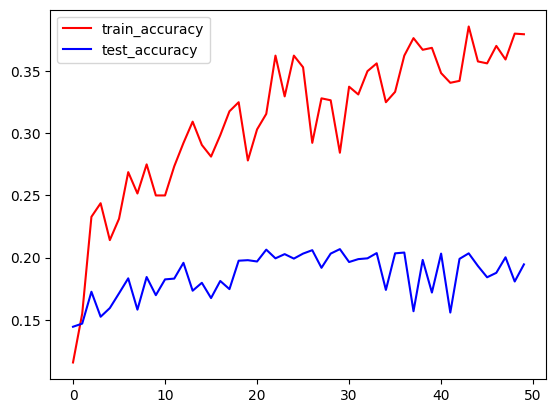

In [26]:
'''
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()
'''

7. Do the same for your `loss`

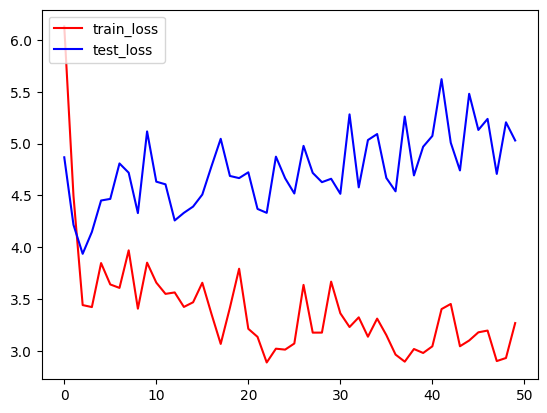

In [27]:
'''
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()
'''

# Fine-Tuning
1. Count the numbers of layers of your pre-trained model

In [9]:
len(base_model.layers)

311

2. Let about 10% of the layers towards the top in trainable status and freeze the rest. You will have to load the pre-trained model again.

In [58]:
base_model = tf.keras.applications.InceptionV3(input_shape=(image_height,image_height,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [59]:
base_model.save("/tf/notebooks/content/skinInceptionV3_BaseModel_512-512.keras")

In [79]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 31
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [69]:
model.save("/tf/notebooks/content/skinInceptionV3_BaseModelFreezed_40.keras")

3. Add some prediction layers to adapt the model to the problem at hand.

In [80]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation="softmax")
])

In [81]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 14, 14, 2048)   │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 6,073,536 (23.17 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

4. Compile the model

In [82]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

5. Train the model using 20 steps per epochs and 50 epochs.

In [40]:
'''model.fit(img_generator_flow_train,
          steps_per_epoch = 346,
          validation_data = img_generator_flow_valid,
          validation_steps = 148,
          epochs = 10)'''

Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 339s 956ms/step - categorical_accuracy: 0.2497 - loss: 3.2307 - val_categorical_accuracy: 0.2403 - val_loss: 2.8788
Epoch 2/10


2024-06-09 05:58:16.860801: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=20, epochs=50)

Epoch 1/50
14/20 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - categorical_accuracy: 0.0592 - loss: 4.2867

In [44]:
model.save("/tf/notebooks/modelSequential1_skinInceptionV3.keras")

In [45]:
import json

In [46]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/tf/notebooks//modelSequential1History_skinInceptionV3.json", 'w'))

In [ ]:
#tf.keras.utils.get_file("/tf/notebooks/content/caltechFineTuningModelHistory.json",
#                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechFineTuningModelHistory.json")

In [ ]:
#history_dict = json.load(open("/tf/notebooks/content/caltechFineTuningModelHistory.json", 'r'))

In [ ]:
#tf.keras.utils.get_file("/content/caltechFineTuningModel.h5",
#                        origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+learning+Images+processing/Transfer+Learning/caltechFineTuningModel.h5")

In [ ]:
#model = tf.keras.models.load_model("/tf/notebooks/content/caltechFineTuningModel.h5")

6. Visualize your `accuracy` on your `train` and on your `test` 

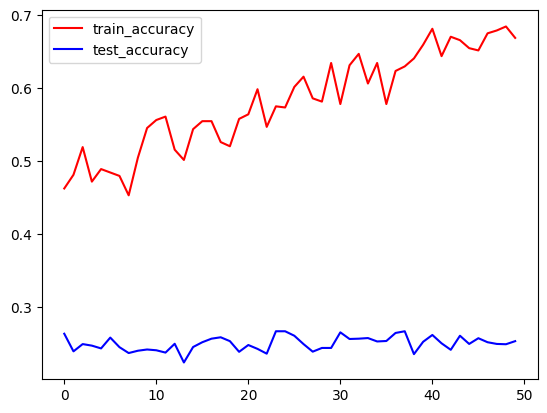

In [47]:
# Visualise train / Valid Accuracy
plt.plot(history_dict["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(history_dict["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

7. Do the same for your `loss`

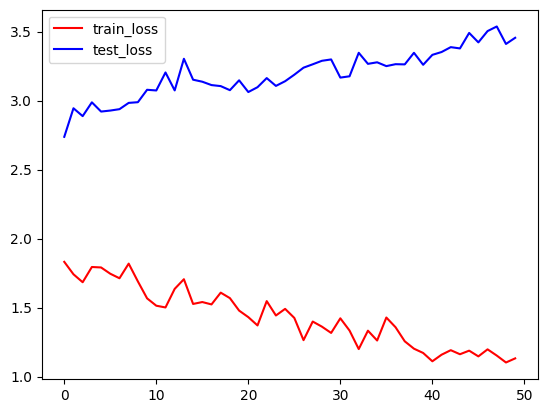

In [48]:
# Visualise train / Valid Loss
plt.plot(history_dict["loss"], c="r", label="train_loss")
plt.plot(history_dict["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# Interpretation with Grad Cam

1. Create an object `imgs` and an object `labels` containing a batch of validation images and validation labels.

In [49]:
imgs, labels = next(iter(img_generator_flow_valid))

2. Get the name of the last convolution layer of the pretrained model and the predicition layers and store them in two variables called respectively `last_conv_layer_name`, and `classifier_layer_names`. 

In [50]:
for layer in model.layers:
  print(layer.name)

inception_v3
max_pooling2d_13
flatten_5
dense_5


In [51]:
base_model = model.layers[0]

In [52]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [53]:
#!pip install pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7


In [54]:
for layer in base_model.layers:
  print(layer.name)

input_layer_4
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_8
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_9
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111
batch_normalization_112
activation_106
activation_108
acti

In [55]:
for layer in model.layers:
  print(layer.name)

inception_v3
max_pooling2d_13
flatten_5
dense_5


In [56]:
last_conv_layer_name = "mixed10"
classifier_layer_names = [layer.name for layer in model.layers][1:]

3. Run the following command, these functions will help you produce the grad cam

In [57]:
# We start by setting up the dependencies we will use

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [58]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

4. Create a `preds` object containing the predicitons from your model on the batch of validation images.

Then create a `pred_labels` object containing the top class predicted for each image in that batch. (You can use the `tf.argmax` function for this)

In [59]:
# Print what the top predicted class is
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)

print("Predicted label:", pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction output: [[6.08121790e-03 8.00540380e-04 1.31955638e-03 1.33882146e-04
  1.31816976e-03 4.00454439e-02 9.17480094e-04 7.72564454e-05
  6.05719379e-07 8.35552514e-02 9.79595585e-04 3.35469749e-03
  1.42673927e-03 3.13787768e-03 9.51773021e-03 8.06885779e-01
  3.12416162e-03 1.35316337e-02 3.18137318e-04 1.94649603e-02
  7.80271730e-05 3.59285437e-03 2.79083652e-05 3.10495147e-04]
 [7.04093790e-03 4.33040224e-03 7.04097911e-05 8.54271057e-04
  3.61374405e-05 8.33391547e-02 4.83611628e-04 1.65436987e-03
  3.02416151e-06 1.13747735e-02 4.27083857e-03 5.94335834e-05
  5.12185460e-03 4.04539192e-03 5.82677254e-04 3.25524695e-02
  2.30185245e-03 7.25721911e-05 8.37961018e-01 4.14226161e-05
  1.05200415e-04 2.06312216e-05 1.03692719e-05 3.66717274e-03]
 [6.22083724e-01 5.20933559e-03 2.47788802e-03 4.11111658e-04
  1.31411338e-02 5.52191725e-03 1.75406254e-04 1.60431646e-05
  1.10058363e-06 5.51884586e-05 7.48343649e-04 2.48090038e-03
  1.17184746e

5. For all the images in the validation batch use the `make_gradcam_heatmap` to create a grad cam heatmap and store them all in a list. Then display the first heatmap.

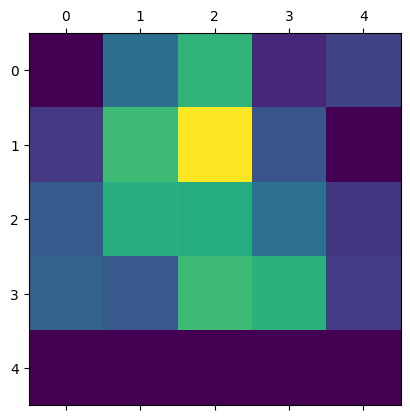

In [60]:
# Generate class activation heatmap
heatmaps = []

for img in imgs:
  heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),base_model, model, last_conv_layer_name, classifier_layer_names
  )
  heatmaps.append(heatmap)


# Display heatmap
plt.matshow(heatmaps[0])
plt.show()


6. Loop over each image, predicted label and heatmap in order to display the images with the superimposed grad cam heatmap and the corresponding predicted label. Do they match the true label? What happens to the grad cam for wrong predictions? Are there any grad cams that seem surprising to you?

In [61]:
from pathlib import Path
import matplotlib

Predicted label: Psoriasis pictures Lichen Planus and related diseases
True label: Tinea Ringworm Candidiasis and other Fungal Infections


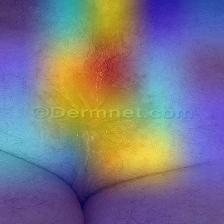

Predicted label: Systemic Disease
True label: Psoriasis pictures Lichen Planus and related diseases


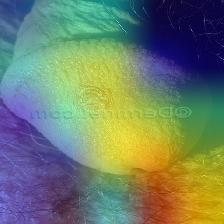

Predicted label: Acne and Rosacea Photos
True label: Acne and Rosacea Photos


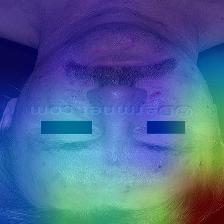

Predicted label: Light Diseases and Disorders of Pigmentation
True label: Scabies Lyme Disease and other Infestations and Bites


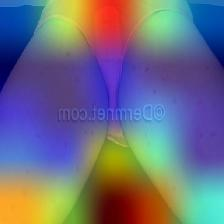

Predicted label: Nail Fungus and other Nail Disease
True label: Warts Molluscum and other Viral Infections


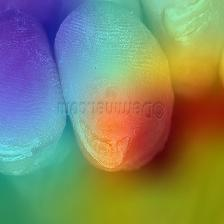

Predicted label: Eczema Photos
True label: Eczema Photos


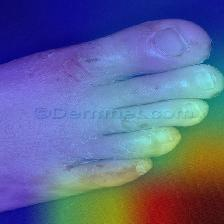

Predicted label: Herpes HPV and other STDs Photos
True label: Vascular Tumors


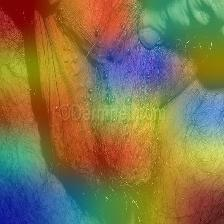

Predicted label: Seborrheic Keratoses and other Benign Tumors
True label: Seborrheic Keratoses and other Benign Tumors


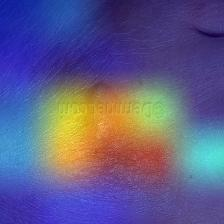

Predicted label: Herpes HPV and other STDs Photos
True label: Tinea Ringworm Candidiasis and other Fungal Infections


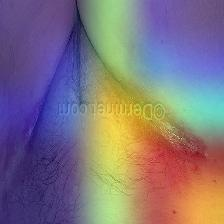

Predicted label: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
True label: Tinea Ringworm Candidiasis and other Fungal Infections


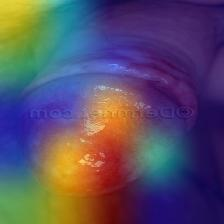

Predicted label: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
True label: Psoriasis pictures Lichen Planus and related diseases


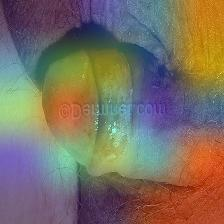

Predicted label: Light Diseases and Disorders of Pigmentation
True label: Warts Molluscum and other Viral Infections


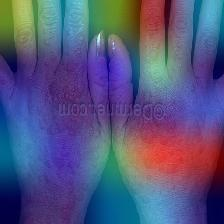

Predicted label: Bullous Disease Photos
True label: Scabies Lyme Disease and other Infestations and Bites


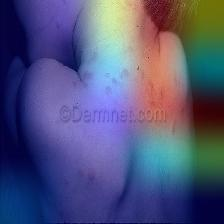

Predicted label: Psoriasis pictures Lichen Planus and related diseases
True label: Seborrheic Keratoses and other Benign Tumors


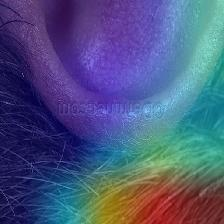

Predicted label: Nail Fungus and other Nail Disease
True label: Nail Fungus and other Nail Disease


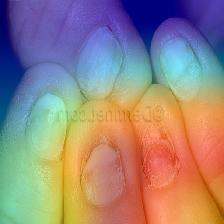

Predicted label: Lupus and other Connective Tissue diseases
True label: Acne and Rosacea Photos


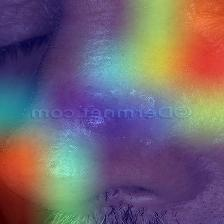

Predicted label: Eczema Photos
True label: Vasculitis Photos


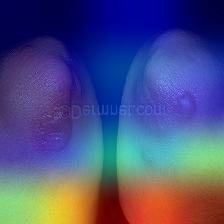

Predicted label: Acne and Rosacea Photos
True label: Acne and Rosacea Photos


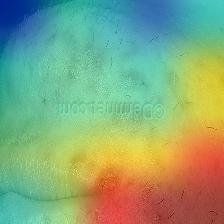

Predicted label: Psoriasis pictures Lichen Planus and related diseases
True label: Tinea Ringworm Candidiasis and other Fungal Infections


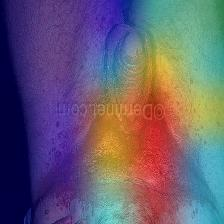

Predicted label: Acne and Rosacea Photos
True label: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions


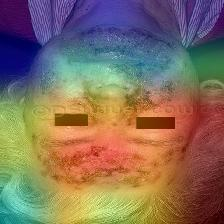

Predicted label: Systemic Disease
True label: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions


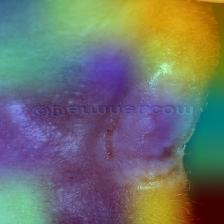

Predicted label: Eczema Photos
True label: Eczema Photos


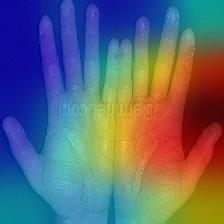

Predicted label: Acne and Rosacea Photos
True label: Eczema Photos


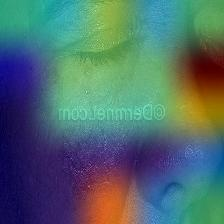

Predicted label: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
True label: Tinea Ringworm Candidiasis and other Fungal Infections


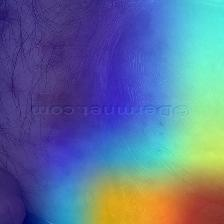

Predicted label: Systemic Disease
True label: Warts Molluscum and other Viral Infections


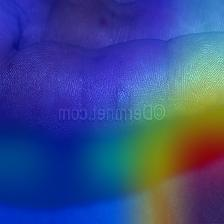

Predicted label: Nail Fungus and other Nail Disease
True label: Bullous Disease Photos


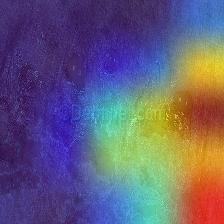

Predicted label: Bullous Disease Photos
True label: Herpes HPV and other STDs Photos


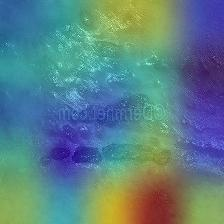

Predicted label: Acne and Rosacea Photos
True label: Acne and Rosacea Photos


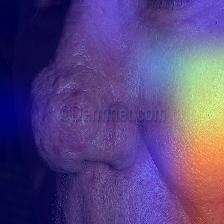

Predicted label: Light Diseases and Disorders of Pigmentation
True label: Bullous Disease Photos


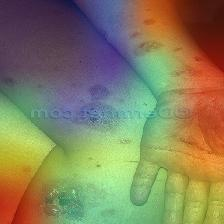

Predicted label: Exanthems and Drug Eruptions
True label: Exanthems and Drug Eruptions


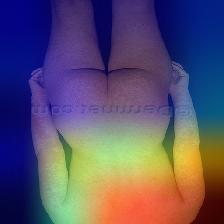

Predicted label: Tinea Ringworm Candidiasis and other Fungal Infections
True label: Systemic Disease


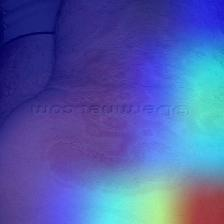

Predicted label: Nail Fungus and other Nail Disease
True label: Eczema Photos


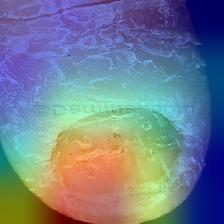

In [63]:
 for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps): 
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = matplotlib.colormaps.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.003 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "saved_img.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  pred_file_path = np.argmax(img_generator_flow_valid.labels == pred_label)
  pred_label_name = Path(img_generator_flow_valid.filepaths[pred_file_path]).parent.name

  true_file_path = np.argmax(img_generator_flow_valid.labels == tf.argmax(true_label))
  true_label_name = Path(img_generator_flow_valid.filepaths[true_file_path]).parent.name

  print("Predicted label:",pred_label_name)
  print("True label:", true_label_name)

  display(Image(save_path))